In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output

import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
from torch.autograd import Variable
import PIL
import torch.optim as optim


ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

 This notebook defines an iterator though the dataset and attempts to train alexnet to take images and map them to predictions of concatenated compressed representations 

# dataset iterator

In [7]:
class Dataset:
    def __init__(self, path):
        self.path=path

    def __getitem__(self, index):
        img = PIL.Image.open(self.path+'/train-%04d.jpg'%index)
        #img = PIL.Image.fromarray(np.stack((img,)*3,-1))
        vect = np.load(self.path+'/train-comp-%04d.npy'%index)
        transform = transforms.Compose([transforms.Resize((227,227)), #224? 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                       ])
        img = transform(img)
        img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

In [8]:
train_data = Dataset('./data/training/')

 # neural net

In [9]:
class AlexNet(nn.Module):

    def __init__(self,D_out):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, D_out),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


 # training loop

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = AlexNet(D_out=500).to(device)
model.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [15]:
losses = [] #track the losses 


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)

In [ ]:
k = 30 #size of batch
N = 100 #number epochs
b = int(len(train_data)/k) #number of batches

running_loss = 0 #avg loss per epoch 
train_loader = DataLoader(train_data, batch_size = k, shuffle = True) #batch data loader

for epoch in range(N): 
    for i, (inputs, targets) in enumerate(train_loader):
        
        # batch 
        inputs, targets = inputs.to(device), targets.to(device)
        clear_output(wait=True)
        
        # zeroed gradients 
        optimizer.zero_grad()
        
        # model prediction
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs,targets)
        running_loss+=loss 
        print('loss:', loss.cpu().data.numpy())
        #backpropagation
        loss.backward()

        #gradient descent 
        optimizer.step()

    # print/store loss
    print(running_loss.cpu().data.numpy()/b)
    losses.append(running_loss/b)
    running_loss=0

loss: 21297.078


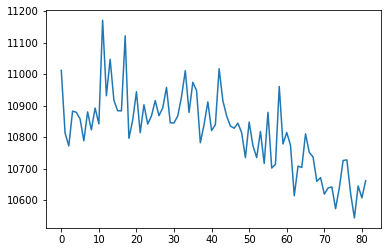

In [41]:
plt.plot(losses)